# Recurrent Neural Networkの使用

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Masking
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import GRU
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


Bad key "text.kerning_factor" on line 4 in
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [2]:
# 予測対象の訓練データ
df_1 = pd.read_csv('train_scores.csv')
display(df_1.head())
print('size : {}'.format(np.shape(df_1)))

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421


size : (5877, 6)


In [3]:
np.unique(df_1['age'], return_counts=True)

(array([14.25726522, 17.22458014, 21.74381885, 25.39336169, 28.44274169,
        30.99738266, 33.40469072, 35.3265819 , 36.96117389, 38.61738057,
        40.12936066, 41.51720254, 42.94115369, 44.42390642, 45.8882136 ,
        47.47020319, 48.94875626, 50.42774666, 51.99651429, 53.5838048 ,
        55.45697773, 57.43607707, 59.58085067, 61.81138167, 64.20310694,
        66.53262952, 68.82092847, 71.41301813, 73.87045558, 76.53864269,
        79.41543791, 81.9080382 , 84.49111251]),
 array([ 17,  45,  90, 120, 144, 162, 186, 186, 168, 191, 186, 198, 218,
        220, 243, 245, 254, 248, 257, 285, 280, 337, 305, 249, 243, 210,
        158, 144, 109,  80,  57,  23,  19], dtype=int64))

- 年齢は各被験者の真値（連続値）ではなく、上記の33個のいずれかに調整されている
- 被験者数は50代が最も多い

ひとまずsMRIの信号データと、fMRIの相関係数データをIDをもとに統合する。

In [9]:
# fMRIの相関係数データをロード
df_fnc = pd.read_csv('fnc.csv')
display(df_fnc.head())
print('size : {}'.format(np.shape(df_fnc)))

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),SMN(11)_vs_SCN(69),SMN(27)_vs_SCN(69),SMN(54)_vs_SCN(69),SMN(66)_vs_SCN(69),SMN(80)_vs_SCN(69),SMN(72)_vs_SCN(69),VSN(16)_vs_SCN(69),VSN(5)_vs_SCN(69),VSN(62)_vs_SCN(69),VSN(15)_vs_SCN(69),VSN(12)_vs_SCN(69),VSN(93)_vs_SCN(69),VSN(20)_vs_SCN(69),VSN(8)_vs_SCN(69),VSN(77)_vs_SCN(69),CON(68)_vs_SCN(69),CON(33)_vs_SCN(69),CON(43)_vs_SCN(69),CON(70)_vs_SCN(69),CON(61)_vs_SCN(69),CON(55)_vs_SCN(69),CON(63)_vs_SCN(69),CON(79)_vs_SCN(69),CON(84)_vs_SCN(69),CON(96)_vs_SCN(69),CON(88)_vs_SCN(69),CON(48)_vs_SCN(69),CON(81)_vs_SCN(69),CON(37)_vs_SCN(69),CON(67)_vs_SCN(69),CON(38)_vs_SCN(69),CON(83)_vs_SCN(69),DMN(32)_vs_SCN(69),DMN(40)_vs_SCN(69),DMN(23)_vs_SCN(69),DMN(71)_vs_SCN(69),DMN(17)_vs_SCN(69),DMN(51)_vs_SCN(69),DMN(94)_vs_SCN(69),CBN(13)_vs_SCN(69),...,DMN(94)_vs_DMN(32),CBN(13)_vs_DMN(32),CBN(18)_vs_DMN(32),CBN(4)_vs_DMN(32),CBN(7)_vs_DMN(32),DMN(23)_vs_DMN(40),DMN(71)_vs_DMN(40),DMN(17)_vs_DMN(40),DMN(51)_vs_DMN(40),DMN(94)_vs_DMN(40),CBN(13)_vs_DMN(40),CBN(18)_vs_DMN(40),CBN(4)_vs_DMN(40),CBN(7)_vs_DMN(40),DMN(71)_vs_DMN(23),DMN(17)_vs_DMN(23),DMN(51)_vs_DMN(23),DMN(94)_vs_DMN(23),CBN(13)_vs_DMN(23),CBN(18)_vs_DMN(23),CBN(4)_vs_DMN(23),CBN(7)_vs_DMN(23),DMN(17)_vs_DMN(71),DMN(51)_vs_DMN(71),DMN(94)_vs_DMN(71),CBN(13)_vs_DMN(71),CBN(18)_vs_DMN(71),CBN(4)_vs_DMN(71),CBN(7)_vs_DMN(71),DMN(51)_vs_DMN(17),DMN(94)_vs_DMN(17),CBN(13)_vs_DMN(17),CBN(18)_vs_DMN(17),CBN(4)_vs_DMN(17),CBN(7)_vs_DMN(17),DMN(94)_vs_DMN(51),CBN(13)_vs_DMN(51),CBN(18)_vs_DMN(51),CBN(4)_vs_DMN(51),CBN(7)_vs_DMN(51),CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10001,0.368580,0.166876,0.438148,0.341007,-0.186251,0.049096,0.121417,-0.174268,-0.231578,0.000947,-0.309387,-0.013269,-0.237781,-0.361850,-0.165181,-0.232689,-0.087128,-0.404605,-0.281643,-0.141046,0.169682,-0.191200,-0.175069,-0.206694,-0.231410,0.047839,0.188612,0.338715,-0.256404,0.028057,-0.224618,-0.239077,0.215035,0.011454,-0.260670,0.447783,-0.064587,0.139647,-0.104753,-0.204877,0.316565,-0.495153,0.069794,0.157164,-0.179685,0.455996,-0.438549,0.081079,-0.340220,...,0.128535,0.303497,0.162034,-0.196496,-0.298840,0.634123,0.553354,0.436383,0.286509,0.633076,-0.274189,0.060903,0.084952,-0.172911,0.425548,0.620014,0.035599,0.705913,-0.198653,0.203644,0.134927,0.041156,0.163678,0.276572,0.387289,-0.063242,0.061152,-0.049253,-0.229196,-0.228465,0.476826,-0.356746,-0.008384,0.136473,0.034347,-0.067857,0.231905,-0.043419,-0.292876,-0.451307,-0.149279,0.552841,0.131046,0.335446,0.394867,-0.042853,0.124627,-0.060712,0.515964,0.290488
1,10002,0.151696,-0.024819,0.217504,0.418072,-0.227234,-0.064052,-0.143832,-0.118116,-0.054825,0.038732,0.035640,0.041466,-0.123721,-0.111059,0.092465,-0.299313,-0.039536,-0.486443,-0.178857,-0.036421,-0.106545,-0.034260,-0.177363,-0.196084,-0.188506,-0.097829,0.162868,-0.198883,-0.199931,-0.201480,-0.296022,0.074729,-0.242173,-0.035884,-0.158039,0.361948,-0.105016,0.050577,0.050343,-0.119580,0.510545,-0.446804,-0.154972,0.137951,-0.286361,0.378998,-0.604789,-0.226727,-0.077109,...,0.118031,-0.016623,-0.111987,-0.057299,0.083966,0.555882,0.618487,0.404051,0.109458,0.794931,-0.289806,-0.297000,0.233930,-0.310834,0.415581,0.692676,-0.289636,0.593502,-0.314787,-0.320460,0.034513,-0.448188,0.210729,0.185737,0.526075,-0.055738,-0.332735,0.309354,-0.245736,-0.426153,0.326195,-0.318364,-0.378719,0.079382,-0.400562,0.039839,0.035288,-0.150326,-0.117559,-0.021944,-0.214216,-0.039792,0.143014,-0.189962,0.498373,0.444231,0.592438,0.028649,0.705524,0.248327
2,10003,0.343415,0.109974,0.741641,0.578558,-0.676446,-0.436960,-0.295663,-0.377790,-0.344963,-0.294511,-0.273254,-0.057660,-0.328309,-0.258488,0.014564,-0.295048,-0.071787,-0.413983,-0.336759,0.018994,0.292083,-0.121689,-0.052

size : (11754, 1379)


In [10]:
# 年齢は四捨五入し整数データに変換する
df_train = df_1.copy()
df_train = np.round(df_train)

In [12]:
# 信号データと相関係数データを統合
df_age = df_train.iloc[:,:2]
df_age = df_age.merge(df_sMRI, on='Id', how='left')
df_age = df_age.merge(df_fnc, on='Id', how='left')

# 年齢順にソートして表示
df_age.sort_values('age')

,Id,age,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,IC_04,IC_12,IC_24,IC_15,IC_13,IC_17,IC_02,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),SMN(11)_vs_SCN(69),SMN(27)_vs_SCN(69),SMN(54)_vs_SCN(69),SMN(66)_vs_SCN(69),SMN(80)_vs_SCN(69),SMN(72)_vs_SCN(69),VSN(16)_vs_SCN(69),VSN(5)_vs_SCN(69),VSN(62)_vs_SCN(69),VSN(15)_vs_SCN(69),VSN(12)_vs_SCN(69),VSN(93)_vs_SCN(69),VSN(20)_vs_SCN(69),...,DMN(94)_vs_DMN(32),CBN(13)_vs_DMN(32),CBN(18)_vs_DMN(32),CBN(4)_vs_DMN(32),CBN(7)_vs_DMN(32),DMN(23)_vs_DMN(40),DMN(71)_vs_DMN(40),DMN(17)_vs_DMN(40),DMN(51)_vs_DMN(40),DMN(94)_vs_DMN(40),CBN(13)_vs_DMN(40),CBN(18)_vs_DMN(40),CBN(4)_vs_DMN(40),CBN(7)_vs_DMN(40),DMN(71)_vs_DMN(23),DMN(17)_vs_DMN(23),DMN(51)_vs_DMN(23),DMN(94)_vs_DMN(23),CBN(13)_vs_DMN(23),CBN(18)_vs_DMN(23),CBN(4)_vs_DMN(23),CBN(7)_vs_DMN(23),DMN(17)_vs_DMN(71),DMN(51)_vs_DMN(71),DMN(94)_vs_DMN(71),CBN(13)_vs_DMN(71),CBN(18)_vs_DMN(71),CBN(4)_vs_DMN(71),CBN(7)_vs_DMN(71),DMN(51)_vs_DMN(17),DMN(94)_vs_DMN(17),CBN(13)_vs_DMN(17),CBN(18)_vs_DMN(17),CBN(4)_vs_DMN(17),CBN(7)_vs_DMN(17),DMN(94)_vs_DMN(51),CBN(13)_vs_DMN(51),CBN(18)_vs_DMN(51),CBN(4)_vs_DMN(51),CBN(7)_vs_DMN(51),CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
3450,16958,14.0,-0.003879,0.013171,0.017052,-0.007297,-0.004322,0.017865,0.011440,0.002947,0.000190,0.024561,-0.004842,0.005050,0.021143,0.017983,0.039672,0.018669,0.015396,0.025031,0.020038,-0.005646,0.025367,0.005233,0.007347,-0.006215,0.030570,0.018119,0.080158,0.105133,0.526088,0.506711,-0.337965,-0.123379,-0.185641,-0.066966,0.032443,-0.098106,-0.239071,-0.196593,-0.225438,-0.319180,-0.170677,-0.253821,-0.124652,-0.412662,-0.285735,-0.133902,0.182523,-0.349034,...,0.136123,0.035928,-0.134037,-0.039581,-0.340026,0.721361,0.457347,0.543705,0.075326,0.767379,-0.012625,0.172563,0.213337,0.071767,0.428714,0.544064,-0.045632,0.745802,0.024189,0.168473,0.251213,0.044656,0.107388,0.259101,0.372826,-0.016340,-0.111860,0.174976,-0.147102,-0.401742,0.425168,0.007310,0.079551,0.159872,0.151191,0.047944,0.018498,-0.010515,-0.176821,-0.153845,-0.034144,0.458317,0.190720,0.378756,0.435077,0.331373,0.302444,0.179038,0.707818,0.330356
2204,14430,14.0,0.004617,0.014784,0.016417,0.000770,-0.006358,0.015111,0.010378,0.001699,0.013860,0.036871,-0.003027,0.002122,0.015760,0.021543,0.046919,0.004562,0.007160,0.016837,0.013190,-0.005849,0.018813,0.001436,0.003202,-0.004856,0.027005,0.014454,0.282221,0.095877,0.535647,0.490660,-0.398432,-0.274796,-0.135322,-0.089396,0.178560,-0.148653,-0.304990,-0.121536,-0.258081,-0.416545,-0.118914,-0.165920,-0.159138,-0.422162,-0.201928,-0.220961,-0.211214,-0.370184,...,0.401536,0.363050,0.020376,-0.047609,-0.419961,0.463949,0.745964,0.347725,0.504185,0.682775,0.127132,0.025706,0.144457,-0.156516,0.485759,0.469317,0.176333,0.574300,0.216214,0.131970,0.082273,0.030530,0.403721,0.399602,0.689106,0.147301,0.097588,0.175261,-0.128680,-0.064177,0.467891,-0.148722,0.154328,0.198347,0.198911,0.199633,0.455091,-0.102477,-0.040710,-0.400893,0.112176,0.413206,0.274302,0.301078,0.252121,0.198240,-0.052774,0.172493,0.472502,0.372749
1952,13914,14.0,0.004755,0.005741,0.011225,-0.003712,-0.002381,0.011389,0.014654,0.001189,0.007098,0.037699,-0.004708,0.006034,0.015930,0.018841,0.050591,0.009405,0.009922,0.018189,0.010198,-0.005772,0.028041,0.003219,0.006726,-0.014898,0.029834,0.016184,0.303667,0.256275,0.520089,0.541853,-0.082880,0.056361,-0.072837,-0.064558,0.251602,0.278037,0.050131,-0.194061,-0.439619,-0.374316,0.014085,-0.346509,-0.246594,-0.414025,-0.350417,-0.310173,-0.080804,-0.398454,...,-0.014136,0.113917,0.023603,-0.173344,-0.372988,0.380394,0.212716,0.324863,0.042206,0.672808,-0.484505,-0.067442,-0.084792,-0.196290,0.386129,0.4406

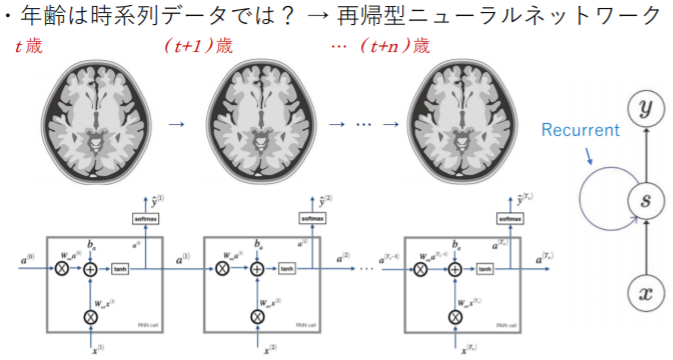

In [1]:
from IPython.display import Image
Image("trends_7.png")

上記のようにRNNの応用を考えた。  
まずは各年齢（t歳）ごとに被験者の説明変数を取り出し平均することで、ある被験者ではなく「t歳の被験者」を表現する。

In [106]:
# 目的変数(y)を取得
X = np.empty([len(y), 1404])
y = np.unique(df_age['age'].values)

# 各年齢毎に説明変数(X)を全て抽出し、平均する
for i in range(len(y)):
    df_temp = df_age[df_age['age']==y[i]]
    X[i] = np.mean(df_temp.iloc[:,2:], axis=0)

# 標準化
sc = StandardScaler()
X_std = sc.fit_transform(X)    
    
print(y.shape)
print(X_std.shape)

(33,)
(33, 1404)


次に、年齢は14, 17, 21...と飛び飛びの値に調整されてしまっているため、この間を補填する。  
方法としては、欠損している年齢は前後の内分点として表現する。  
間が1歳しか開いていない場合は、平均となる。  
例：（15歳データ）=（14歳データ）×2/3 + （17歳データ）×1/3

In [28]:
X_f = X_std.copy()

# 年齢ごとのインクリメント数（k）
k = 0
for i in range(32):
    y_1 = y[i]
    y_2 = y[i+1]
    # 年齢差（d）
    d = int(y_2 - y_1)
    # 年齢差が2以上の時、内分点を計算
    if d >= 2:
        for j in range(1,d):
            X_temp = X[i]*(d-j)/d + X[i+1]*j/d
            # 内分点を該当する位置に挿入
            X_f = np.insert(X_f, i+k+1, X_temp, axis=0)
            k += 1
    # 年齢差が1の場合は次へ
    else: 
        pass

print(X_f.shape)

(71, 1404)


これで、訓練データに含まれていた14～84歳（71通り）の範囲で、各年齢の被験者が表現できたと考える。  

本来RNNは時刻 $t \sim t+n$ の状態を入力し、時刻 $t+n+1$ の状態を予測するために使用される。  
しかし今回予測したいのは一つ先の時刻の脳データではなく、ある脳データを入力して時刻（シーケンス）である $t$ の値を出力させる形にしなくてはならない。  


そこで、14～84歳まで年齢順に並べた脳データ全体から、予測対象である被験者の脳データを引き算したもの（$\mathbb{R}^{71 \times 1404}$の配列）を説明変数として入力し、SimpleRNNやLSTM等のRNNを何層か重ねた後に全結合層（Dense）を挟んで、14～84のうちいずれなのかを多値分類させる、という方法を考えた。

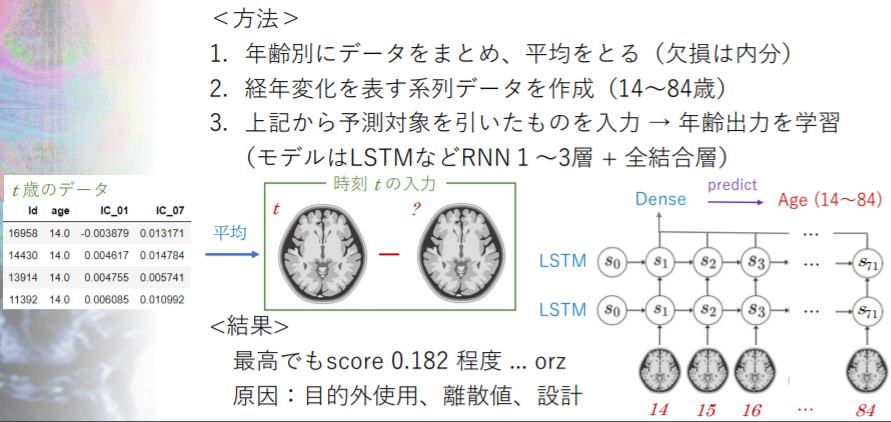

In [2]:
Image("trends_8.png")

In [33]:
# 全被検者(5877人)分の入力データを初期化
x = np.empty([5877, 71, 1404])

# 標準化
x_temp = df_age.iloc[:,2:].values
sc_x = StandardScaler()
x_std = sc_x.fit_transform(x_temp)

# 14～84歳の系列データ(X_f)から被検者データ（x_std）を引く
# これを入力データ（x）とする
for i in range(5877):
    x[i] = X_f - x_std[i]

In [35]:
x.shape

(5877, 71, 1404)

$\mathbb{R}^{71 \times 1404}$の入力配列が、5877人分生成された

In [60]:
# 正解ラベル（y）の読み込み
y = df_age['age'].values
y

array([57., 60., 71., ..., 49., 67., 69.])

In [61]:
# train/validationへ分割
# 年齢比率に違いが生じぬよう、yで層化する
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y)

In [68]:
# Denseからsoftmaxで出力するので、yをone-hot変換(y_oh)
y_tr = (y_train - 14).astype(int)
y_tr_oh = np.identity(71)[y_tr]
y_vl = (y_val - 14).astype(int)
y_vl_oh = np.identity(71)[y_vl]

print(y_tr_oh.shape)
print(y_vl_oh.shape)

(4701, 71)
(1176, 71)


Kerasを使用していくつかモデルを定義し、学習・推論・評価を行う。

### 1. LSTM×2→Dense

In [53]:
model = Sequential()
model.add(LSTM(702, return_sequences=True, input_shape=(71, 1404)))
model.add(LSTM(702)) 
model.add(Dense(71, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 71, 702)           5916456   
_________________________________________________________________
lstm_9 (LSTM)                (None, 702)               3945240   
_________________________________________________________________
dense_1 (Dense)              (None, 71)                49913     
Total params: 9,911,609
Trainable params: 9,911,609
Non-trainable params: 0
_________________________________________________________________


In [70]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_tr_oh, 
          batch_size=47, epochs=10,
          validation_data=(x_val, y_vl_oh), 
          callbacks=[early_stopping])


Train on 4701 samples, validate on 1176 samples
Epoch 1/10
4701/4701 [==============================] - 344s 73ms/step - loss: 3.4144 - mean_absolute_error: 0.0271 - val_loss: 3.2432 - val_mean_absolute_error: 0.0269
Epoch 2/10
4701/4701 [==============================] - 341s 73ms/step - loss: 3.1259 - mean_absolute_error: 0.0267 - val_loss: 3.1419 - val_mean_absolute_error: 0.0267
Epoch 3/10
4701/4701 [==============================] - 344s 73ms/step - loss: 2.9651 - mean_absolute_error: 0.0263 - val_loss: 3.1729 - val_mean_absolute_error: 0.0267
Epoch 4/10
4701/4701 [==============================] - 344s 73ms/step - loss: 2.7543 - mean_absolute_error: 0.0257 - val_loss: 3.2696 - val_mean_absolute_error: 0.0266
Epoch 5/10
4701/4701 [==============================] - 337s 72ms/step - loss: 2.4840 - mean_absolute_error: 0.0244 - val_loss: 3.4213 - val_mean_absolute_error: 0.0264
Epoch 6/10
4701/4701 [==============================] - 343s 73ms/step - loss: 2.0520 - mean_absolute_erro

In [72]:
preds = model.predict(x_val)

In [79]:
predicts = np.argmax(preds, axis=1)
predicts = predicts + 14
predicts

array([57, 71, 69, ..., 50, 69, 57], dtype=int64)

In [80]:
y_val

array([33., 60., 62., ..., 50., 64., 52.])

In [82]:
score = np.sum(np.abs(predicts - y_val)) / np.sum(predicts)
score

0.18513085514252375

### 2. SimpleRNN×2→Dense

In [83]:
model_1 = Sequential()
model_1.add(SimpleRNN(702, return_sequences=True, input_shape=(71, 1404)))
model_1.add(SimpleRNN(702)) 
model_1.add(Dense(71, activation='softmax'))
model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['mean_absolute_error'])
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 71, 702)           1479114   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 702)               986310    
_________________________________________________________________
dense_2 (Dense)              (None, 71)                49913     
Total params: 2,515,337
Trainable params: 2,515,337
Non-trainable params: 0
_________________________________________________________________


In [84]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model_1.fit(x_train, y_tr_oh, 
            batch_size=47, epochs=10,
            validation_data=(x_val, y_vl_oh), 
            callbacks=[early_stopping])

Train on 4701 samples, validate on 1176 samples
Epoch 1/10
4701/4701 [==============================] - 110s 23ms/step - loss: 3.6146 - mean_absolute_error: 0.0271 - val_loss: 3.4495 - val_mean_absolute_error: 0.0271
Epoch 2/10
4701/4701 [==============================] - 104s 22ms/step - loss: 3.4017 - mean_absolute_error: 0.0270 - val_loss: 3.2888 - val_mean_absolute_error: 0.0268
Epoch 3/10
4701/4701 [==============================] - 103s 22ms/step - loss: 3.3069 - mean_absolute_error: 0.0269 - val_loss: 3.2871 - val_mean_absolute_error: 0.0268
Epoch 4/10
4701/4701 [==============================] - 101s 21ms/step - loss: 3.2317 - mean_absolute_error: 0.0267 - val_loss: 3.1759 - val_mean_absolute_error: 0.0267
Epoch 5/10
4701/4701 [==============================] - 102s 22ms/step - loss: 3.2051 - mean_absolute_error: 0.0267 - val_loss: 3.3857 - val_mean_absolute_error: 0.0267
Epoch 6/10
4701/4701 [==============================] - 102s 22ms/step - loss: 3.1588 - mean_absolute_error

In [86]:
preds_1 = model_1.predict(x_val)

In [87]:
predicts_1 = np.argmax(preds_1, axis=1)
predicts_1 = predicts_1 + 14

score_1 = np.sum(np.abs(predicts_1 - y_val)) / np.sum(predicts_1)
score_1

0.21946379022032747

### 3. GRU×2→Dense

In [88]:
model_2 = Sequential()
model_2.add(GRU(702, return_sequences=True, input_shape=(71, 1404)))
model_2.add(GRU(702)) 
model_2.add(Dense(71, activation='softmax'))
model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['mean_absolute_error'])
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 71, 702)           4437342   
_________________________________________________________________
gru_2 (GRU)                  (None, 702)               2958930   
_________________________________________________________________
dense_3 (Dense)              (None, 71)                49913     
Total params: 7,446,185
Trainable params: 7,446,185
Non-trainable params: 0
_________________________________________________________________


In [89]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model_2.fit(x_train, y_tr_oh, 
            batch_size=47, epochs=10,
            validation_data=(x_val, y_vl_oh), 
            callbacks=[early_stopping])

Train on 4701 samples, validate on 1176 samples
Epoch 1/10
4701/4701 [==============================] - 444s 94ms/step - loss: 3.6001 - mean_absolute_error: 0.0269 - val_loss: 3.3782 - val_mean_absolute_error: 0.0267
Epoch 2/10
4701/4701 [==============================] - 461s 98ms/step - loss: 3.0427 - mean_absolute_error: 0.0261 - val_loss: 3.3663 - val_mean_absolute_error: 0.0267
Epoch 3/10
4701/4701 [==============================] - 452s 96ms/step - loss: 2.6203 - mean_absolute_error: 0.0248 - val_loss: 3.7128 - val_mean_absolute_error: 0.0265
Epoch 4/10
4701/4701 [==============================] - 448s 95ms/step - loss: 1.9802 - mean_absolute_error: 0.0215 - val_loss: 3.8978 - val_mean_absolute_error: 0.0264
Epoch 5/10
4701/4701 [==============================] - 450s 96ms/step - loss: 1.0832 - mean_absolute_error: 0.0144 - val_loss: 4.6903 - val_mean_absolute_error: 0.0264
Epoch 6/10
4701/4701 [==============================] - 499s 106ms/step - loss: 0.7780 - mean_absolute_erro

In [90]:
preds_2 = model_2.predict(x_val)

In [91]:
predicts_2 = np.argmax(preds_2, axis=1)
predicts_2 = predicts_2 + 14

score_2 = np.sum(np.abs(predicts_2 - y_val)) / np.sum(predicts_2)
score_2

0.18883186622710124

同じ条件下では、LSTM, GRU, SimpleRNNの順に精度が良い結果となった。  
勾配消失の問題が軽減されている影響なのだろうか？  
しかし精度としてはパラメータチューニングしていないLightGBMにも及んでいない...

LSTMの層数・ノード数をいくつか変更して試してみる。

### 4. LSTM×3→Dense

In [93]:
model_3 = Sequential()
model_3.add(LSTM(500, return_sequences=True, input_shape=(71, 1404)))
model_3.add(LSTM(500, return_sequences=True))
model_3.add(LSTM(500))
model_3.add(Dense(71, activation='softmax'))
model_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['mean_absolute_error'])
model_3.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 71, 500)           3810000   
_________________________________________________________________
lstm_14 (LSTM)               (None, 71, 500)           2002000   
_________________________________________________________________
lstm_15 (LSTM)               (None, 500)               2002000   
_________________________________________________________________
dense_4 (Dense)              (None, 71)                35571     
Total params: 7,849,571
Trainable params: 7,849,571
Non-trainable params: 0
_________________________________________________________________


In [94]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model_3.fit(x_train, y_tr_oh, 
            batch_size=47, epochs=10,
            validation_data=(x_val, y_vl_oh), 
            callbacks=[early_stopping])

Train on 4701 samples, validate on 1176 samples
Epoch 1/10
4701/4701 [==============================] - 392s 83ms/step - loss: 3.4149 - mean_absolute_error: 0.0271 - val_loss: 3.2116 - val_mean_absolute_error: 0.0268
Epoch 2/10
4701/4701 [==============================] - 431s 92ms/step - loss: 3.1784 - mean_absolute_error: 0.0268 - val_loss: 3.1581 - val_mean_absolute_error: 0.0268
Epoch 3/10
4701/4701 [==============================] - 377s 80ms/step - loss: 3.0357 - mean_absolute_error: 0.0265 - val_loss: 3.1401 - val_mean_absolute_error: 0.0266
Epoch 4/10
4701/4701 [==============================] - 367s 78ms/step - loss: 2.8991 - mean_absolute_error: 0.0262 - val_loss: 3.2447 - val_mean_absolute_error: 0.0266
Epoch 5/10
4701/4701 [==============================] - 366s 78ms/step - loss: 2.7783 - mean_absolute_error: 0.0260 - val_loss: 3.1905 - val_mean_absolute_error: 0.0265
Epoch 6/10
4701/4701 [==============================] - 382s 81ms/step - loss: 2.6379 - mean_absolute_error

In [95]:
preds_3 = model_3.predict(x_val)

In [96]:
predicts_3 = np.argmax(preds_3, axis=1)
predicts_3 = predicts_3 + 14

score_3 = np.sum(np.abs(predicts_3 - y_val)) / np.sum(predicts_3)
score_3

0.18330162830066843

層数を増やしたことにより、若干のscore改善が見られた。  
しかしこれ以上試行錯誤しても、scoreの改善は難しそう...


別の方法として、先ほどは系列データから被検者データを引いたものを入力としたが、今後は系列データを被検者データで割ったものを入力としてみる。

In [100]:
# 14～84歳の系列データ(X_f)を被検者データ（x_std）で割る
# これを入力データ（z）とする
z = np.empty([5877, 71, 1404])

for i in range(5877):
    z[i] = X_f / x_std[i]

In [102]:
# train/validationへ分割
# 年齢比率に違いが生じぬよう、yで層化する
z_train, z_val, y_train, y_val = train_test_split(z, y, test_size=0.2, stratify=y)

In [103]:
# Denseからsoftmaxで出力するので、yをone-hot変換(y_oh)
y_tr = (y_train - 14).astype(int)
y_tr_oh = np.identity(71)[y_tr]
y_vl = (y_val - 14).astype(int)
y_vl_oh = np.identity(71)[y_vl]

print(z_train.shape)
print(z_val.shape)
print(y_tr_oh.shape)
print(y_vl_oh.shape)

(4701, 71, 1404)
(1176, 71, 1404)
(4701, 71)
(1176, 71)


先ほどと同様、2層のLSTMで試す。

In [101]:
model_4 = Sequential()
model_4.add(LSTM(702, return_sequences=True, input_shape=(71, 1404)))
model_4.add(LSTM(702)) 
model_4.add(Dense(71, activation='softmax'))
model_4.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['mean_absolute_error'])
model_4.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 71, 702)           5916456   
_________________________________________________________________
lstm_17 (LSTM)               (None, 702)               3945240   
_________________________________________________________________
dense_5 (Dense)              (None, 71)                49913     
Total params: 9,911,609
Trainable params: 9,911,609
Non-trainable params: 0
_________________________________________________________________


In [104]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model_4.fit(z_train, y_tr_oh, 
            batch_size=47, epochs=10,
            validation_data=(z_val, y_vl_oh), 
            callbacks=[early_stopping])

Train on 4701 samples, validate on 1176 samples
Epoch 1/10
4701/4701 [==============================] - 407s 87ms/step - loss: 3.6239 - mean_absolute_error: 0.0273 - val_loss: 3.4366 - val_mean_absolute_error: 0.0271
Epoch 2/10
4701/4701 [==============================] - 432s 92ms/step - loss: 2.7412 - mean_absolute_error: 0.0248 - val_loss: 3.7627 - val_mean_absolute_error: 0.0271
Epoch 3/10
4701/4701 [==============================] - 431s 92ms/step - loss: 1.2565 - mean_absolute_error: 0.0139 - val_loss: 4.4446 - val_mean_absolute_error: 0.0272
Epoch 4/10
4701/4701 [==============================] - 420s 89ms/step - loss: 0.3691 - mean_absolute_error: 0.0048 - val_loss: 4.8482 - val_mean_absolute_error: 0.0270
Epoch 5/10
4701/4701 [==============================] - 415s 88ms/step - loss: 0.1551 - mean_absolute_error: 0.0020 - val_loss: 4.8621 - val_mean_absolute_error: 0.0271
Epoch 6/10
4701/4701 [==============================] - 414s 88ms/step - loss: 0.0768 - mean_absolute_error

In [105]:
preds_4 = model_4.predict(z_val)
predicts_4 = np.argmax(preds_4, axis=1)
predicts_4 = predicts_4 + 14

score_4 = np.sum(np.abs(predicts_4 - y_val)) / np.sum(predicts_4)
score_4

0.2995498912658676

sc oreは大きく悪化しており、割ったものを入力とするのは不適切のようだ...


### <考察>
年齢に時系列性を見出してRNNモデルでの学習・推論を試みたが、通常の回帰問題として扱う以上の性能を実現させることはできなかった。原因として以下の3つが考えられる。

1. RNNの目的外使用である  
    上記でも述べたように本来RNNは時刻 $t \sim t+n$ の入力から時刻 $t+n+1$ の状態を予測するもので、今回のように時刻の値を予測するものではない。この問題を解決しようと試行錯誤してみたが、今回の方法では上手くいかなかった。
    

2. 連続値ではなく、14～84歳のいずれかという離散値の予測である 
    1.の問題を解決するため今回は半ば強引に年齢を出力させる形をとり、多値分類の問題に帰着させてしまった。このためう予測値は1歳刻みとなり、より細かいスケールでの予測ができなくなったこともscoreが上がらなかった原因と考えられえる。  
    また与えられたデータ自体も生データではなく、匿名性のため33通りの値のいずれかに調整されてしまっていたことも、時系列性を詳細に反映できなかった原因と思われる。


3. 次元の呪い
    今回は、学習に使用できるsample数5877に対し特徴量数が1404と多くなってしまっている。これに加えてRNNでは時系列順にデータを並べるため、さらに次元数も増加し学習がうまく進まなかった可能性が考えららる。ガウス過程回帰では次元削減としてPCAやLDAを試み、この時はうまくいかなかったが、RNNでも次元削減を考慮すべきであったのかもしれない。